# Lane Detection with TuSimple Dataset
Using U-Net
1. Configuration
2. Data Preprocessing (JSON to Masks)
3. Dataset Loading
4. Model Architecture (U-Net)
5. Training Loop
6. Inference & Visualization
7. Execution
8. Evaluation

Save the Confusion Matrix while the validation

differentiation of lanes: arc loss, distance between lanes. 
last layer 
instance segmentation

+3 credits: from instance segmentation -> shape of lane markings scipy make_splprep

## 1. Configuration
Define paths, hyperparameters, and device settings.


In [1]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

BASE_DIR = os.getcwd()
DATA_DIR = r'C:\Users\Alex\Documents\Clase\Italia\Segundo_ano\ADAS\Project\TU_Simple_folder\TUSimple' 
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
TEST_SET_DIR = os.path.join(DATA_DIR, 'test_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, r'processed\instance')
CHECKPOINT_DIR = os.path.join(BASE_DIR, r'checkpoints\instance')

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hyperparameters
EPOCHS = 20 #20+ for final training
BATCH_SIZE = 16 # calculate based on GPU memory 
LEARNING_RATE = 5*1e-4 
WEIGHT_DECAY = 1e-4 
NUM_CLASSES = 6  # background + all lanes 
IMG_HEIGHT = 288 # resize target height
IMG_WIDTH = 512  # resize target width

# save model checkpoints
model_filename = f'best_model_instance_e{EPOCHS}_dropout.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)
eval_filename = f'best_model_instance_e{EPOCHS}_dropout.pth'
EVAL_MODEL_PATH = os.path.join(CHECKPOINT_DIR, eval_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Data Preprocessing
Functions to parse TuSimple JSON labels and generate segmentation masks.


In [2]:
def process_tusimple_data(data_dir, output_dir, json_files):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for json_file in json_files:
        json_path = os.path.join(data_dir, json_file)

        with open(json_path, 'r') as openfile: #read json file 
            lines = openfile.readlines()

        for line in tqdm(lines, desc=f"Processing {json_file}"):
            info = json.loads(line)
            raw_file = info['raw_file']
            lanes = info['lanes']
            h_samples = info['h_samples']
            
            # create mask assuming 1280x720
            mask = np.zeros((720, 1280), dtype=np.uint8)

            # lanes[0] -> Class 1
            # lanes[1] -> Class 2
            for i, lane in enumerate(lanes):
                # Skip if lane is all -2 (empty)
                if all(x == -2 for x in lane):
                    continue
                    
                points = []
                for x, y in zip(lane, h_samples):
                    if x != -2:
                        points.append((x, y))
                
                if len(points) > 1:
                    class_id = i + 1
                    cv2.polylines(mask, [np.array(points, dtype=np.int32)], isClosed=False, color=class_id, thickness=10) 
                    
            # save mask
            mask_rel_path = raw_file.replace('.jpg', '.png')
            mask_save_path = os.path.join(output_dir, mask_rel_path)
            
            os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
            cv2.imwrite(mask_save_path, mask)

## 3. Dataset Definition
PyTorch Dataset class to load images and masks.


In [3]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, transform=None):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.transform = transform
        self.samples = []

        # load all samples from json files
        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path):
                continue
                
            with open(json_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                info = json.loads(line)
                raw_file = info['raw_file']
                mask_file = raw_file.replace('.jpg', '.png')
                
                self.samples.append((raw_file, mask_file))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel_path, mask_rel_path = self.samples[idx]
        
        img_path = os.path.join(self.root_dir, img_rel_path)
        mask_path = os.path.join(self.processed_dir, mask_rel_path)
        
        # load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # resize and normalize
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) # channel first
      
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()
        
        return image, mask


## 4. Model Architecture (U-Net)

In [4]:
class DoubleConv(nn.Module):
    #(convolution => [BN] => ReLU) * 2
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # padding=1
        mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2) #may be used for overfitting of lane 4-5
        )

    def forward(self, x):
        return self.double_conv(x)

Encoder - downsampling:

In [5]:
class Down(nn.Module):
    #downscaling with maxpool then double conv    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 256x256 -> 128x128
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


Decoder - upsampling:

In [6]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsample  
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 previous layer 
        # x2 corresponding encoder layer (skip connection)
        x1 = self.up(x1)
        
        # calculate the difference in size between x1 (upsampled) and x2 (skip connection)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # Pad x1 to match the size of x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 1x1 convolution to map feature channels to the number of classes
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Final:

In [8]:
class UNet(nn.Module): 
    #full unet
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # define encoder sizes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        # define decoder sizes
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # encoder 
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # decoder - with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # final
        out = self.outc(x) 
        return out

## 5. Training Loop


In [9]:
def train_model():
    # dataset
    json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
    
    full_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)
    
    # split into train and val
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device) # 3 channels for R,G,B 
    
    # loss and optimizer (instance seg -> adding other lane weights)
    class_weights = torch.tensor([0.4, 1.0, 1.0, 1.0, 1.0, 1.0], device=device) # background, lanes
    criterion_ce = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    best_val_loss = float('inf') # checkpoint
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}") 
        
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)
            
            # forward pass
            outputs = model(images)
            
            loss_ce = criterion_ce(outputs, masks)
            loss = loss_ce
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        avg_train_loss = train_loss / len(train_loader)
        
        # validation
        model.eval()
        val_loss = 0
        conf_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                loss_ce = criterion_ce(outputs, masks)
                loss = loss_ce
                val_loss += loss.item()
                
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                preds_flat = preds.view(-1).cpu().numpy()
                masks_flat = masks.view(-1).cpu().numpy()
                
                bins = NUM_CLASSES * masks_flat + preds_flat
                bincount = np.bincount(bins, minlength=NUM_CLASSES**2)
                conf_matrix += bincount.reshape(NUM_CLASSES, NUM_CLASSES)
        
        avg_val_loss = val_loss / len(val_loader)
        
        # Calculate F1 and IoU from Confusion Matrix
        intersection = np.diag(conf_matrix)
        union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
        iou = intersection / np.maximum(union, 1)
        
        tp = intersection
        fp = conf_matrix.sum(axis=0) - tp
        fn = conf_matrix.sum(axis=1) - tp
        f1 = 2 * tp / np.maximum(2 * tp + fp + fn, 1)
        
        mean_iou = np.nanmean(iou[1:]) # Skip background
        mean_f1 = np.nanmean(f1[1:])
        
        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Val Mean IoU: {mean_iou:.4f}, Val Mean F1: {mean_f1:.4f}")
        
        # Save Confusion Matrix
        cm_filename = f"confusion_matrix_e{EPOCHS}.npy"
        cm_path = os.path.join(CHECKPOINT_DIR, cm_filename)
        np.save(cm_path, conf_matrix)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print("Saved best model checkpoint.")

## 6. Inference & Visualization


In [10]:
def lane_detection_prediction(image_path, model_path, output_path):
    # load model
    model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # load image
    example_image = cv2.imread(image_path)
    
    image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB) #convert to RGB
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) #resize to match input size
    image = image.astype(np.float32) / 255.0 #normalize
    image = np.transpose(image, (2, 0, 1)) #channels first
    image = torch.from_numpy(image).float().unsqueeze(0).to(device) 

    # inference
    with torch.no_grad():
        output = model(image)
        probs = torch.softmax(output, dim=1)
        pred_mask = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()
    
    # Resize to Original Size
    pred_mask_resized = cv2.resize(pred_mask.astype(np.uint8), (example_image.shape[1], example_image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    colors = [
        [0, 0, 0],       # Background
        [0, 255, 0],     # Lane 1 (Green)
        [255, 0, 0],     # Lane 2 (Red)
        [0, 0, 255],     # Lane 3 (Blue)
        [255, 255, 0],   # Lane 4 (Yellow)
        [255, 0, 255]    # Lane 5 (Magenta)
    ]
    
    #Morphological Closing & Filtering 
    overlay = np.zeros_like(example_image)
    kernel = np.ones((5, 5), np.uint8)
    
    for i in range(1, NUM_CLASSES):
        class_mask = (pred_mask_resized == i).astype(np.uint8)
        
        # 1. Close gaps (Dilation -> Erosion)
        closed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)
        
        # 2. Connected Components on Closed Mask
        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(closed_mask)
        
        for j in range(1, num_labels):
            area = stats[j, cv2.CC_STAT_AREA]
            height = stats[j, cv2.CC_STAT_HEIGHT]
            
            # Relaxed Filtering: Area > 250 AND Height > 20
            if area >= 250 and height >= 20:
                valid_mask = (labels_im == j)
                overlay[valid_mask] = colors[i]

    result = cv2.addWeighted(example_image, 1, overlay, 0.5, 0) 

    cv2.imwrite(output_path, result)
    print(f"Saved result to {output_path}")
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 7. Execution
Execution of the training functions and inference. 


In [11]:
# 1. Run Preprocessing
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
process_tusimple_data(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

Processing label_data_0601.json: 100%|██████████| 410/410 [00:01<00:00, 348.23it/s]


In [ ]:
# 2. Train Model
#train_model()

Saved result to instance_result.jpg


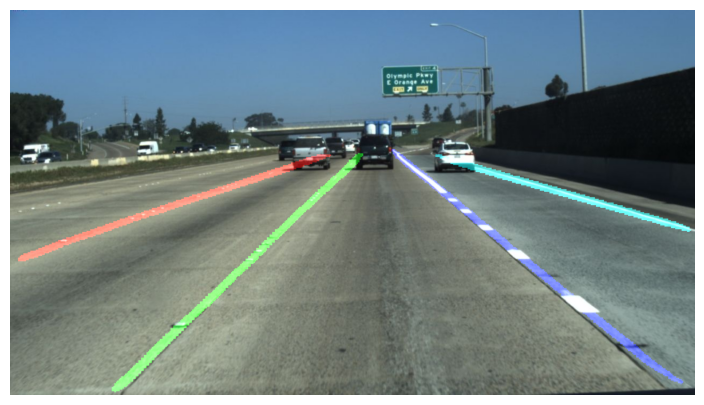

Saved result to instance_result2.jpg


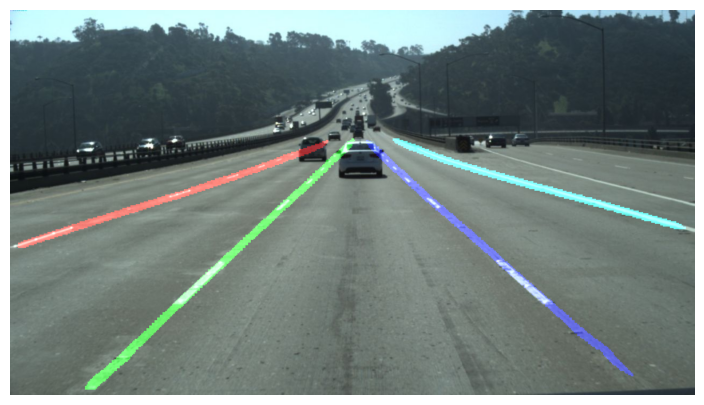

Saved result to instance_result3.jpg


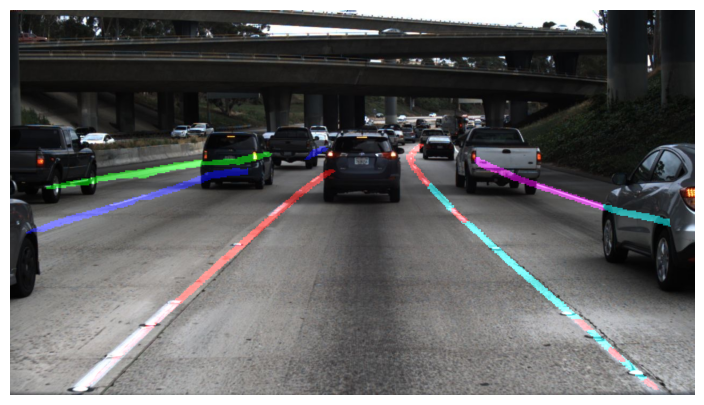

In [12]:
# 3. Inference
test_image_path1 = os.path.join(TRAIN_SET_DIR, 'clips/0313-2/50/10.jpg') # Example image
test_image_path2 = os.path.join(TRAIN_SET_DIR, 'clips/0313-1/1800/10.jpg') 
test_image_path3 = os.path.join(TRAIN_SET_DIR, 'clips/0601/1494452553518276564/20.jpg') 
lane_detection_prediction(test_image_path1, BEST_MODEL_PATH, 'instance_result.jpg')
lane_detection_prediction(test_image_path2, BEST_MODEL_PATH, 'instance_result2.jpg')
lane_detection_prediction(test_image_path3, BEST_MODEL_PATH, 'instance_result3.jpg')

## 8. Evaluation
Calculate IoU and Accuracy on the Test Set.


In [13]:
def calculate_tolerance_iou(pred_mask, true_mask, num_classes, tolerance=5):
    # Tolerance IoU: Dilate GT to allow slack
    iou_per_class = []
    kernel = np.ones((tolerance, tolerance), np.uint8)
    
    for cls in range(num_classes):
        if cls == 0: 
            # Standard IoU for background - usually not relevant for tolerance but kept for consistency
            p = (pred_mask == cls)
            t = (true_mask == cls)
            inter = np.logical_and(p, t).sum()
            union = np.logical_or(p, t).sum()
            iou_per_class.append(inter / union if union > 0 else np.nan)
            continue

        pred_cls = (pred_mask == cls).astype(np.uint8)
        true_cls = (true_mask == cls).astype(np.uint8)
        
        # Dilate Ground Truth
        dilated_true = cv2.dilate(true_cls, kernel, iterations=1)
        
        intersection = np.logical_and(pred_cls, dilated_true).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        
        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_per_class.append(intersection / union)
            
    return iou_per_class


In [ ]:
def evaluate(model, test_loader, device, val_cm_path=None, plotmode=False, num_visualize = 3):
    # mode: 'eval' for full evaluation, 'plot' for just random usage
    
    model.eval()
    
    colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255]]
    kernel = np.ones((5, 5), np.uint8)
    
    viz_samples = []
    
    if plotmode==False:
        # Load Validation Metrics
        if val_cm_path and os.path.exists(val_cm_path):
            val_cm = np.load(val_cm_path)
            v_inter = np.diag(val_cm)
            v_union = val_cm.sum(axis=1) + val_cm.sum(axis=0) - v_inter
            val_iou = v_inter / np.maximum(v_union, 1)
            v_tp = v_inter
            v_fp = val_cm.sum(axis=0) - v_tp
            v_fn = val_cm.sum(axis=1) - v_tp
            val_f1 = 2 * v_tp / np.maximum(2 * v_tp + v_fp + v_fn, 1)
            print(f"\nValidation Mean IoU: {np.nanmean(val_iou[1:]):.4f}")
            print(f"Validation Mean F1:  {np.nanmean(val_f1[1:]):.4f}")
        
        test_cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
        total_tol_iou = []
        
        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc="Evaluating Test Set"):
                images = images.to(device)
                masks_np = masks.cpu().numpy()
                masks = masks.to(device)
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                raw_preds = torch.argmax(probs, dim=1).cpu().numpy()
                processed_preds = np.zeros_like(raw_preds)
                
                for b in range(len(raw_preds)):
                    img_pred = raw_preds[b]
                    for cls in range(1, NUM_CLASSES):
                        class_mask = (img_pred == cls).astype(np.uint8)
                        closed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)
                        num_labels, labels_im, stats, _ = cv2.connectedComponentsWithStats(closed_mask)
                        for j in range(1, num_labels):
                            area = stats[j, cv2.CC_STAT_AREA]
                            height = stats[j, cv2.CC_STAT_HEIGHT]
                            if area >= 250 and height >= 20:
                                 processed_preds[b][labels_im == j] = cls
                
                for i in range(len(masks_np)):
                    p_flat = processed_preds[i].flatten()
                    t_flat = masks_np[i].flatten()
                    bins = NUM_CLASSES * t_flat + p_flat
                    bincount = np.bincount(bins, minlength=NUM_CLASSES**2)
                    test_cm += bincount.reshape(NUM_CLASSES, NUM_CLASSES)
                    tol_iou = calculate_tolerance_iou(processed_preds[i], masks_np[i], NUM_CLASSES, tolerance=5)
                    total_tol_iou.append(tol_iou)
                    
                    if len(viz_samples) < num_visualize:
                        img_np = images[i].cpu().permute(1, 2, 0).numpy()
                        img_np = (img_np * 255).astype(np.uint8)
                        img_np_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
                        viz_samples.append((img_np_rgb, masks_np[i], processed_preds[i]))
        
        t_inter = np.diag(test_cm)
        t_union = test_cm.sum(axis=1) + test_cm.sum(axis=0) - t_inter
        test_iou = t_inter / np.maximum(t_union, 1)
        t_tp = t_inter
        t_fp = test_cm.sum(axis=0) - t_tp
        t_fn = test_cm.sum(axis=1) - t_tp
        test_f1 = 2 * t_tp / np.maximum(2 * t_tp + t_fp + t_fn, 1)
        mean_tol_iou = np.nanmean(total_tol_iou, axis=0)
        
        print(f"Test Mean IoU:       {np.nanmean(test_iou[1:]):.4f}")
        print(f"Test Mean F1:        {np.nanmean(test_f1[1:]):.4f}")
        print(f"Test Mean Tol IoU:   {np.nanmean(mean_tol_iou[1:]):.4f}\n")
        
        for i in range(1, NUM_CLASSES):
            print(f"Lane {i}: Val IoU: {val_iou[i]:.4f}, Test IoU: {test_iou[i]:.4f}, Test Tol IoU: {mean_tol_iou[i]:.4f}, Val F1: {val_f1[i]:.4f}, Test F1: {test_f1[i]:.4f}")
        
        # Save & Plot CM
        test_cm_path = os.path.join(CHECKPOINT_DIR, "test_confusion_matrix.npy")
        np.save(test_cm_path, test_cm)
        print(f"Saved Test Confusion Matrix to {test_cm_path}")
        
        plt.figure(figsize=(10, 8))
        plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Test Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(NUM_CLASSES)
        plt.xticks(tick_marks, tick_marks)
        plt.yticks(tick_marks, tick_marks)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        thresh = test_cm.max() / 2.
        for i in range(test_cm.shape[0]):
            for j in range(test_cm.shape[1]):
                plt.text(j, i, format(test_cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if test_cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.show()
    
    elif plotmode:
        # Sample random indices
        total_samples = len(test_loader.dataset)
        indices = np.random.choice(total_samples, num_visualize, replace=False)
        
        # Create a subset loader
        subset = torch.utils.data.Subset(test_loader.dataset, indices)
        viz_loader = DataLoader(subset, batch_size=1, shuffle=False)
        
        with torch.no_grad():
            for images, masks in tqdm(viz_loader, desc="Visualizing Random Samples"):
                images = images.to(device)
                masks_np = masks.cpu().numpy()
                
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                raw_preds = torch.argmax(probs, dim=1).cpu().numpy()[0] # Batch size 1
                
                # Apply Morphology (Single Image)
                processed_pred = np.zeros_like(raw_preds)
                for cls in range(1, NUM_CLASSES):
                    class_mask = (raw_preds == cls).astype(np.uint8)
                    closed_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)
                    num_labels, labels_im, stats, _ = cv2.connectedComponentsWithStats(closed_mask)
                    for j in range(1, num_labels):
                        if stats[j, cv2.CC_STAT_AREA] >= 250 and stats[j, cv2.CC_STAT_HEIGHT] >= 20:
                             processed_pred[labels_im == j] = cls
                
                img_np = images[0].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
                img_np_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
                viz_samples.append((img_np_rgb, masks_np[0], processed_pred))

    # Common Visualization
    if len(viz_samples) > 0:
        rows = len(viz_samples)
        fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows), squeeze=False)
        for idx, (img, gt, pred) in enumerate(viz_samples):
            ax_row = axes[idx]
            ax_row[0].imshow(img)
            ax_row[0].set_title("Input")
            ax_row[0].axis('off')
            
            ov_gt = img.copy()
            ov_pred = img.copy()
            for c in range(1, NUM_CLASSES):
                 ov_gt[gt==c] = colors[c]
                 ov_pred[pred==c] = colors[c]
                 
            ax_row[1].imshow(ov_gt)
            ax_row[1].set_title("Ground Truth")
            ax_row[1].axis('off')
            
            ax_row[2].imshow(ov_pred)
            ax_row[2].set_title(f"Pred (Procesed)")
            ax_row[2].axis('off')
        plt.show()


Evaluating Test Set: 100%|██████████| 174/174 [39:19<00:00, 13.56s/it]



Validation Mean IoU: 0.4401
Validation Mean F1:  0.5994
Test Mean IoU:       0.3451
Test Mean F1:        0.4968
Test Mean Tol IoU:   0.4576

Lane 1: Val IoU: 0.4806, Test IoU: 0.5537, Test Tol IoU: 0.7786, Val F1: 0.6492, Test F1: 0.7127
Lane 2: Val IoU: 0.4853, Test IoU: 0.4200, Test Tol IoU: 0.6233, Val F1: 0.6535, Test F1: 0.5916
Lane 3: Val IoU: 0.5215, Test IoU: 0.3743, Test Tol IoU: 0.4908, Val F1: 0.6855, Test F1: 0.5447
Lane 4: Val IoU: 0.5187, Test IoU: 0.1940, Test Tol IoU: 0.2136, Val F1: 0.6831, Test F1: 0.3250
Lane 5: Val IoU: 0.1945, Test IoU: 0.1834, Test Tol IoU: 0.1817, Val F1: 0.3257, Test F1: 0.3100


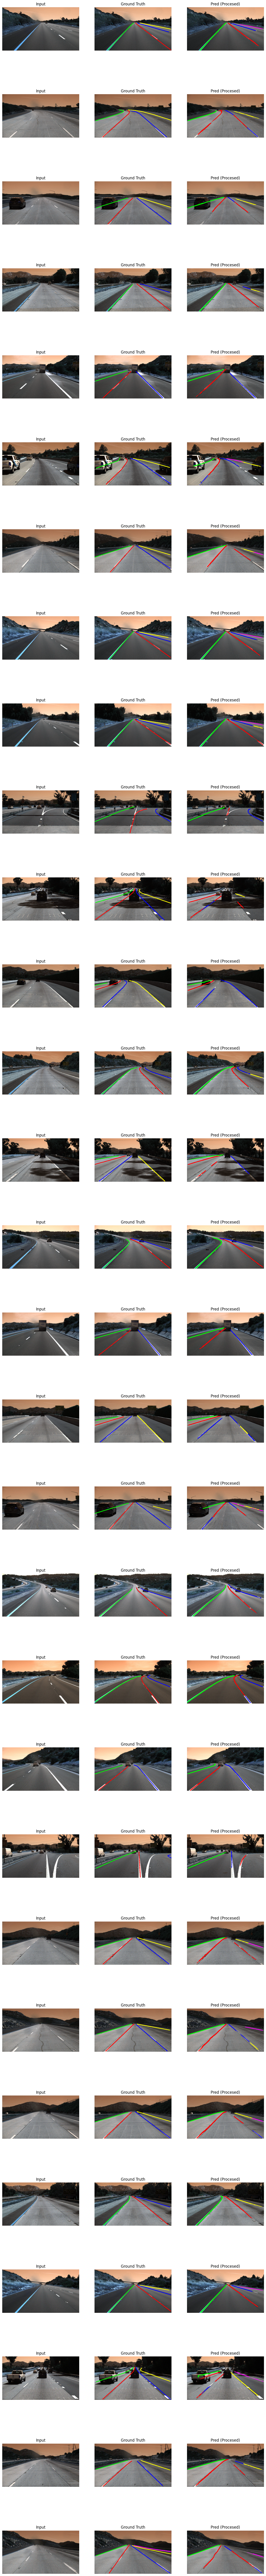

In [ ]:
test_json_files = ['test_label.json']
process_tusimple_data(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)

test_dataset = TuSimpleDataset(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(EVAL_MODEL_PATH, map_location=device))

val_cm_path = os.path.join(CHECKPOINT_DIR, f"confusion_matrix_e{EPOCHS}.npy")

evaluate(model, test_loader, device, val_cm_path=val_cm_path, plotmode=False, num_visualize=5)

In [ ]:
evaluate(model, test_loader, device, val_cm_path=val_cm_path, plotmode=True, num_visualize=30)